<a href="https://colab.research.google.com/github/vbvss199/colab_notebooks/blob/main/DeepLearningProject2_finale.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Setting Up the Environment and Dependencies

In [ ]:
!pip install super-gradients torch torchvision pycocotools


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 684.5/684.5 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of albumentations to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of albumentations to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.3/108.3 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


2. import necessary modules

In [ ]:
import os
import torch
from super_gradients.training import models, Trainer
from super_gradients.training import Trainer, dataloaders, models
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.dataloaders.dataloaders import (
    coco_detection_yolo_format_train,
    coco_detection_yolo_format_val
)
from super_gradients.training.models.detection_models.pp_yolo_e import (
    PPYoloEPostPredictionCallback
)
#for data visualization
import matplotlib.pyplot as plt
import cv2

The console stream is logged into /root/sg_logs/console.log


[2024-11-13 20:15:34] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it
[2024-11-13 20:15:48] INFO - utils.py - NumExpr defaulting to 2 threads.


In [ ]:
class Config:
    CHECKPOINT_DIR = '/content/drive/MyDrive/College car parking space-20241109T021439Z-001/checkpoints'
    EXPERIMENT_NAME = 'race_number' #specify the experiment name
    #dataset params
    DATA_DIR = '/content/drive/MyDrive/College car parking space-20241109T021439Z-001/car parking space.v1i.coco'
    TRAIN_IMAGES_DIR = '/content/drive/MyDrive/College car parking space-20241109T021439Z-001/car parking space.v1i.coco/train/images'
    TRAIN_LABELS_DIR = '/content/drive/MyDrive/College car parking space-20241109T021439Z-001/car parking space.v1i.coco/train/labels'
    VAL_IMAGES_DIR = '/content/drive/MyDrive/College car parking space-20241109T021439Z-001/car parking space.v1i.coco/valid/images'
    VAL_LABELS_DIR = '/content/drive/MyDrive/College car parking space-20241109T021439Z-001/car parking space.v1i.coco/valid/labels'
    TEST_IMAGES_DIR = '/content/drive/MyDrive/College car parking space-20241109T021439Z-001/car parking space.v1i.coco/test/images'
    TEST_LABELS_DIR = '/content/drive/MyDrive/College car parking space-20241109T021439Z-001/car parking space.v1i.coco/test/labels'
    CLASSES = ['free_parking_space', 'not_free_parking_space', 'partially_free_parking_space','person']
    NUM_CLASSES = len(CLASSES)
    DATALOADER_PARAMS = {
        'batch_size': 8,
        'num_workers': 2
    }
config = Config()

3.generating individuals labels for the coco model

In [ ]:
import json
import os

def convert_coco_to_yolo(coco_json_path, output_dir):
    with open(coco_json_path, 'r') as f:
        coco_data = json.load(f)

    # Create directories if they don't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    images = {image['id']: image for image in coco_data['images']}
    annotations = coco_data['annotations']

    for ann in annotations:
        image_id = ann['image_id']
        image_info = images[image_id]
        image_filename = os.path.splitext(image_info['file_name'])[0]
        label_filename = os.path.join(output_dir, image_filename + '.txt')

        # YOLO format: <object-class> <x_center> <y_center> <width> <height>
        x_center = (ann['bbox'][0] + ann['bbox'][2] / 2) / image_info['width']
        y_center = (ann['bbox'][1] + ann['bbox'][3] / 2) / image_info['height']
        width = ann['bbox'][2] / image_info['width']
        height = ann['bbox'][3] / image_info['height']

        # Assuming 'category_id' starts from 0 and matches the indices in config.CLASSES
        category_id = ann['category_id'] - 1

        with open(label_filename, 'a') as f:
            f.write(f"{category_id} {x_center} {y_center} {width} {height}\n")

# Convert train annotations
convert_coco_to_yolo('/content/drive/MyDrive/College car parking space-20241109T021439Z-001/car parking space.v1i.coco/train/_annotations.coco.json','/content/drive/MyDrive/College car parking space-20241109T021439Z-001/car parking space.v1i.coco/train/labels')

# Convert validation annotations
convert_coco_to_yolo('/content/drive/MyDrive/College car parking space-20241109T021439Z-001/car parking space.v1i.coco/valid/_annotations.coco.json','/content/drive/MyDrive/College car parking space-20241109T021439Z-001/car parking space.v1i.coco/valid/labels')

# Convert test annotations
convert_coco_to_yolo('/content/drive/MyDrive/College car parking space-20241109T021439Z-001/car parking space.v1i.coco/test/_annotations.coco.json','/content/drive/MyDrive/College car parking space-20241109T021439Z-001/car parking space.v1i.coco/test/labels')


In [ ]:
train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': config.DATA_DIR,
        'images_dir': config.TRAIN_IMAGES_DIR,
        'labels_dir': config.TRAIN_LABELS_DIR,
        'classes': config.CLASSES
    },
    dataloader_params=config.DATALOADER_PARAMS
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': config.DATA_DIR,
        'images_dir': config.VAL_IMAGES_DIR,
        'labels_dir': config.VAL_LABELS_DIR,
        'classes': config.CLASSES
    },
    dataloader_params=config.DATALOADER_PARAMS
)

test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': config.DATA_DIR,
        'images_dir': config.TEST_IMAGES_DIR,
        'labels_dir': config.TEST_LABELS_DIR,
        'classes': config.CLASSES
    },
    dataloader_params=config.DATALOADER_PARAMS
)

[2024-11-13 20:19:01] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 140/140 [00:32<00:00,  4.28it/s]
[2024-11-13 20:19:34] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 40/40 [00:09<00:00,  4.33it/s]
[2024-11-13 20:19:44] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations:  95%|█████████▌| 19/20 [00:04<00:00,  4.10it/s]

Indexing dataset annotations: 100%|██████████| 20/20 [00:04<00:00,  4.15it/s]


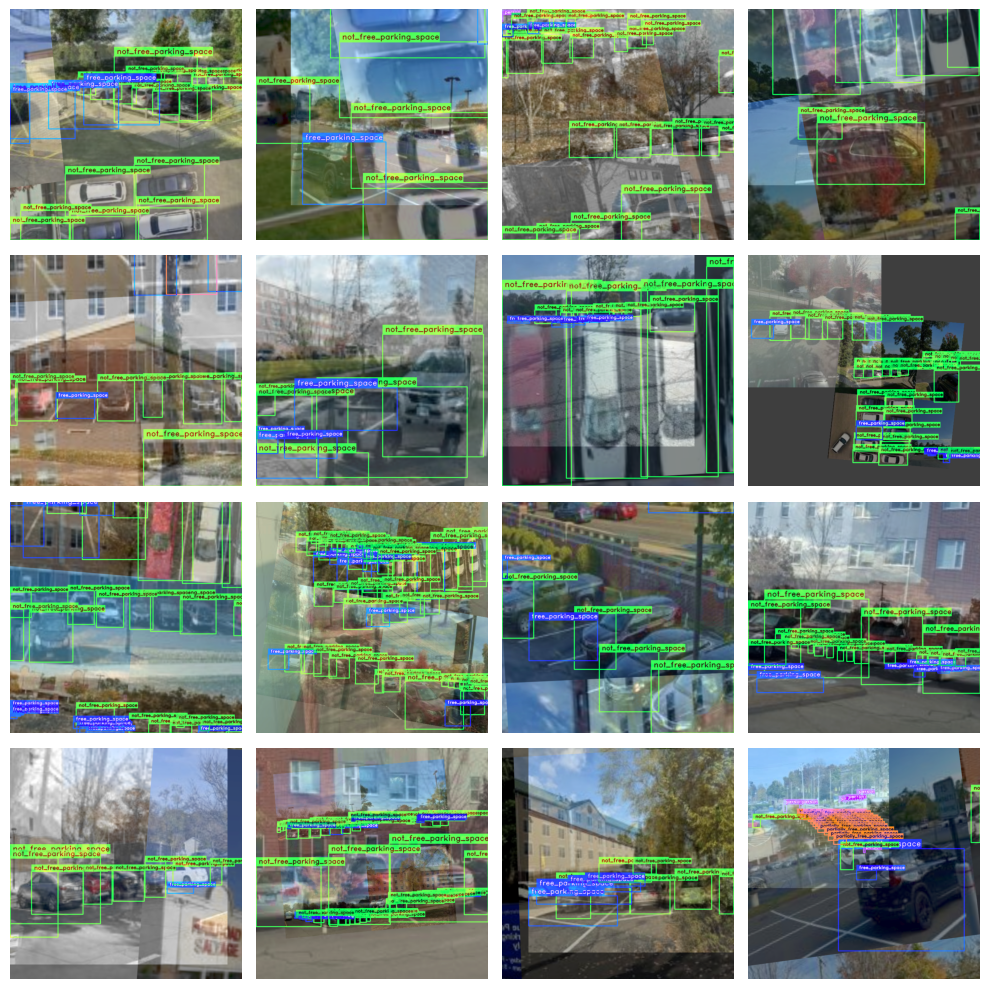

In [ ]:
train_data.dataset.plot()

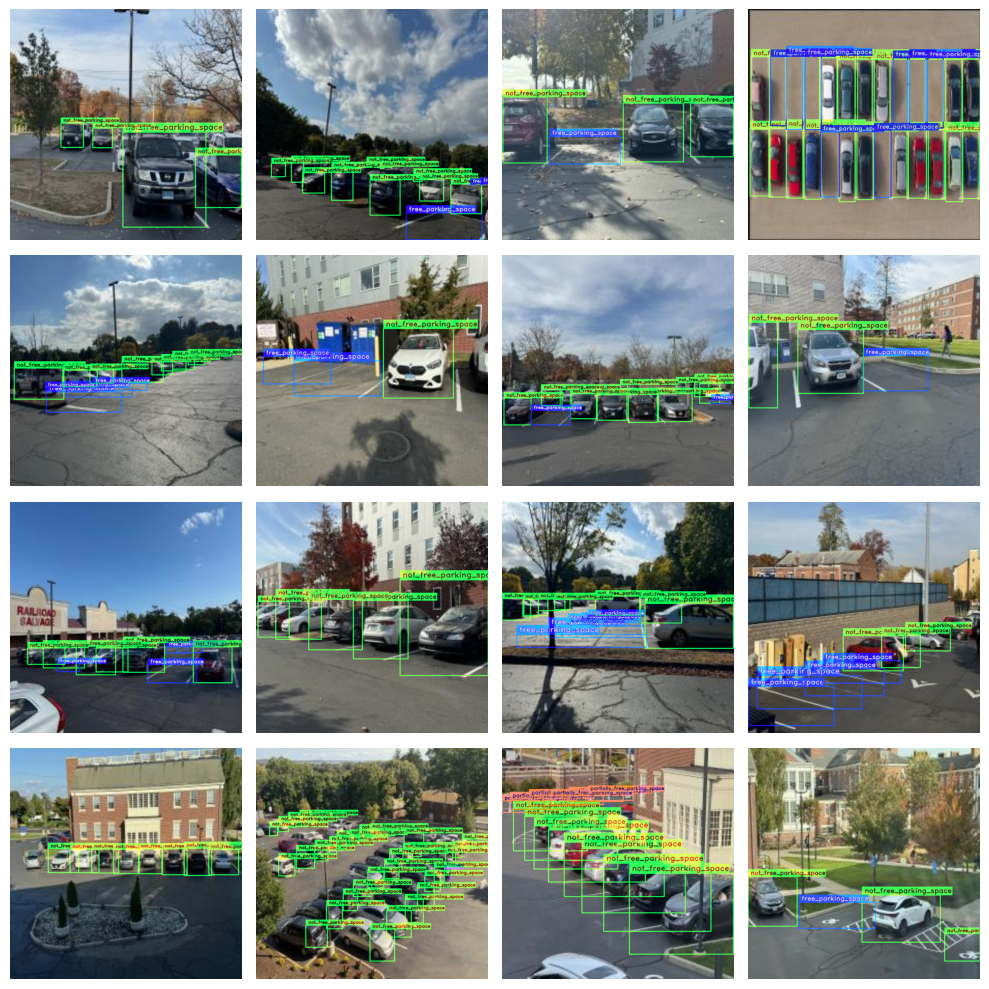

In [ ]:
test_data.dataset.plot()

In [ ]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class ParkingSpaceDataset(Dataset):
    def __init__(self, images_dir, labels_dir, classes, transform=None):
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.classes = classes
        self.transform = transform
        self.image_paths = [os.path.join(images_dir, img) for img in os.listdir(images_dir) if img.endswith(('.png', '.jpg', '.jpeg'))]
        self.label_paths = [os.path.join(labels_dir, label) for label in os.listdir(labels_dir) if label.endswith('.txt')]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label_path = self.label_paths[idx]

        # Load image
        image = Image.open(img_path).convert("RGB")

        # Load and parse label
        with open(label_path, 'r') as f:
            labels = f.readlines()

        # Extract class indices and bounding box coordinates
        targets = []
        for label in labels:
            parts = label.strip().split()
            class_idx = int(parts[0])
            bbox = list(map(float, parts[1:]))
            targets.append([class_idx] + bbox)  # You can change this format as per your requirement

        # Convert targets to tensor
        targets = torch.tensor(targets)

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        return image, targets

# Define the transforms
transform = transforms.Compose([
    transforms.Resize((416, 416)),
    transforms.ToTensor()
])

# Create dataset instances with the transformation applied
train_dataset = ParkingSpaceDataset(
    images_dir=os.path.join(config.DATA_DIR, config.TRAIN_IMAGES_DIR),
    labels_dir=os.path.join(config.DATA_DIR, config.TRAIN_LABELS_DIR),
    classes=config.CLASSES,
    transform=transform
)

val_dataset = ParkingSpaceDataset(
    images_dir=os.path.join(config.DATA_DIR, config.VAL_IMAGES_DIR),
    labels_dir=os.path.join(config.DATA_DIR, config.VAL_LABELS_DIR),
    classes=config.CLASSES,
    transform=transform
)

test_dataset = ParkingSpaceDataset(
    images_dir=os.path.join(config.DATA_DIR, config.TEST_IMAGES_DIR),
    labels_dir=os.path.join(config.DATA_DIR, config.TEST_LABELS_DIR),
    classes=config.CLASSES,
    transform=transform
)

# Custom collate function to handle varying sizes or types
def custom_collate_fn(batch):
    images, labels = zip(*batch)
    images = torch.stack(images, 0)
    return images, labels  # Note: Labels might not need stacking depending on format

# Create DataLoader instances
train_loader = DataLoader(train_dataset, batch_size=config.DATALOADER_PARAMS['batch_size'], shuffle=True, num_workers=config.DATALOADER_PARAMS['num_workers'], collate_fn=custom_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=config.DATALOADER_PARAMS['batch_size'], shuffle=False, num_workers=config.DATALOADER_PARAMS['num_workers'], collate_fn=custom_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=config.DATALOADER_PARAMS['batch_size'], shuffle=False, num_workers=config.DATALOADER_PARAMS['num_workers'], collate_fn=custom_collate_fn)


In [ ]:
!git clone https://github.com/ultralytics/yolov5.git
%cd yolov5
!pip install -r requirements.txt


Cloning into 'yolov5'...
remote: Enumerating objects: 17045, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 17045 (delta 10), reused 18 (delta 8), pack-reused 17022 (from 1)
Receiving objects: 100% (17045/17045), 15.67 MiB | 24.39 MiB/s, done.
Resolving deltas: 100% (11704/11704), done.
/content/yolov5
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 56.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.8/883.8 kB 41.9 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.0
    Uninstalling numpy-1.23.0:
      Successfully uninstalled numpy-1.23.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following depe

In [ ]:
import yaml

# Define the data configuration
data_config = {
    'train': '/content/drive/MyDrive/College car parking space-20241109T021439Z-001/car parking space.v1i.coco/train',
    'val': '/content/drive/MyDrive/College car parking space-20241109T021439Z-001/car parking space.v1i.coco/valid',
    'test': '/content/drive/MyDrive/College car parking space-20241109T021439Z-001/car parking space.v1i.coco/test',
    'nc': 4,
    'names': ['free_parking_space', 'not_free_parking_space', 'partially_free_parking_space', 'person']
}

# Save the configuration to a YAML file
data_yaml = '/content/data.yaml'
with open(data_yaml, 'w') as file:
    yaml.dump(data_config, file)

print(f"Data configuration saved to {data_yaml}")


Data configuration saved to /content/data.yaml


In [ ]:
import os
from pathlib import Path

# Set the path to the YOLOv5 repository
yolov5_repo_path = Path('/content/yolov5')

# Change the working directory to the YOLOv5 repository
%cd {yolov5_repo_path}

# Train the YOLOv5 model using the custom dataset
!python train.py --img 640 --batch 8 --epochs 10 --data {data_yaml} --weights yolov5s.pt --cache


/content/yolov5
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2024-11-13 20:23:23.087798: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-13 20:23:23.126797: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-13 20:23:23.138499: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452

In [ ]:
import torch
from pathlib import Path

# Set the path to the YOLOv5 repository
yolov5_repo_path = Path('/content/yolov5')

# Change the working directory to the YOLOv5 repository
%cd {yolov5_repo_path}

# Load the pre-trained YOLOv5 model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)  # or use your own model

# Modify the final detection layer to match the number of classes in your dataset
num_classes = 4  # Your number of classes
model.nc = num_classes  # Set the number of classes to match your dataset

# Check the model summary
print(model)

# Train the model using your custom dataset
!python train.py --img 640 --batch 8 --epochs 10 --data {data_yaml} --weights 'yolov5s.pt' --cache

/content/yolov5


Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-11-13 Python-3.10.12 torch-2.5.0+cu121 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


AutoShape(
  (model): DetectMultiBackend(
    (model): DetectionModel(
      (model): Sequential(
        (0): Conv(
          (conv): Conv2d(3, 32, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
          (act): SiLU(inplace=True)
        )
        (1): Conv(
          (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (act): SiLU(inplace=True)
        )
        (2): C3(
          (cv1): Conv(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv2): Conv(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv3): Conv(
            (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (m): Sequential(
            (0): Bottleneck(
              (cv1): Conv(
                (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  

In [ ]:
# Save the modified model if needed (optional)
torch.save(model.state_dict(), 'parking_space_detection_11_13_2024_16:028.pt')

 Inference with the Model


In [ ]:
import torch

# Load the custom-trained model
model = torch.load('/content/yolov5/parking_space_detection_11_13_2024_16:028.pt')

model


OrderedDict([('model.model.model.0.conv.weight',
              tensor([[[[ 3.72679e-03,  1.28580e-01,  1.34893e-01,  2.91734e-01,  1.65096e-01,  1.44216e-01],
                        [ 9.58527e-02,  2.49392e-01,  2.84353e-01,  3.85353e-01,  2.49198e-01,  1.71117e-01],
                        [ 6.13282e-02,  2.40263e-01,  3.77972e-01,  4.73534e-01,  2.02194e-01,  7.05542e-02],
                        [ 7.98772e-02,  1.91900e-01,  2.94647e-01,  3.52140e-01,  5.86576e-02, -4.00843e-02],
                        [-1.49266e-01, -7.83719e-02, -4.28035e-02, -1.41545e-02, -2.46090e-01, -3.21257e-01],
                        [-2.77944e-01, -2.76390e-01, -3.36407e-01, -2.39680e-01, -3.64182e-01, -3.44565e-01]],
              
                       [[-2.55413e-02,  1.49072e-02, -2.90374e-02,  1.05370e-01,  4.49400e-02,  1.15567e-01],
                        [ 9.69209e-02,  1.85976e-01,  1.60823e-01,  2.30163e-01,  1.24016e-01,  1.29746e-01],
                        [ 1.13431e-01,  2.28415e-01,  3

In [ ]:
model = torch.hub.load("/content/yolov5", "custom", path="/content/yolov5/parking_space_detection_11_13_2024_16:028.pt", source="local")

Exception: 'model'. Cache may be out of date, try `force_reload=True` or see https://docs.ultralytics.com/yolov5/tutorials/pytorch_hub_model_loading for help.

YOLOv5 🚀 2024-11-13 Python-3.10.12 torch-2.5.0+cu121 CPU



In [ ]:
import torch
import cv2
from matplotlib import pyplot as plt
from utils.general import non_max_suppression
%matplotlib inline

In [ ]:
# Define the missing scale_coords function
def scale_coords(img1_shape, coords, img0_shape, ratio_pad=None):
    """
    Rescales coords (xyxy) from img1_shape to img0_shape.
    :param img1_shape: tuple (h, w) shape of image 1
    :param coords: tensor (n, 4) of xyxy normalized coordinates to be scaled
    :param img0_shape: tuple (h, w) shape of image 0
    :param ratio_pad: tuple (ratio, pad) optional scaling factor
    :return: coords tensor (n, 4) of scaled coordinates
    """
    if ratio_pad is None:  # calculate from img1_shape to img0_shape
        gain = min(img1_shape[0] / img0_shape[0], img1_shape[1] / img0_shape[1])  # gain (wh ratio)
        pad = (img1_shape[1] - img0_shape[1] * gain) / 2, (img1_shape[0] - img0_shape[0] * gain) / 2  # wh padding
    else:
        gain = ratio_pad[0]
        pad = ratio_pad[1]

    coords[:, [0, 2]] -= pad[0]  # x padding
    coords[:, [1, 3]] -= pad[1]  # y padding
    coords[:, :4] /= gain
    coords[:, :4].clamp_(min=0, max=max(img0_shape))  # clamp
    return coords

In [ ]:
# Function to perform inference and display the result
def predict_and_display(image_path):
    # Load an image
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Prepare image
    img_resized = cv2.resize(img_rgb, (640, 640))
    img_tensor = torch.from_numpy(img_resized).permute(2, 0, 1).float().div(255.0).unsqueeze(0).to(device)

    # Perform inference
    with torch.no_grad():
        results = model(img_tensor)
        results = non_max_suppression(results, conf_thres=0.25, iou_thres=0.45)

    # Draw bounding boxes
    for det in results:
        if det is not None:
            det[:, :4] = scale_coords(img_tensor.shape[2:], det[:, :4], img.shape).round()
            for *xyxy, conf, cls in det:
                label = f'{model.names[int(cls)]} {conf:.2f}'
                cv2.rectangle(img_rgb, (int(xyxy[0]), int(xyxy[1])), (int(xyxy[2]), int(xyxy[3])), (0, 255, 0), 2)
                cv2.putText(img_rgb, label, (int(xyxy[0]), int(xyxy[1]) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Display the results
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.show()

# Example usage
image_path = '/content/1.png'
predict_and_display(image_path)

TypeError: 'collections.OrderedDict' object is not callable